In [1]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import Tensor
import einops
from datasets import load_dataset
from welford_torch import OnlineCovariance, Welford
from taker import Model

# m = Model("facebook/galactica-125m", dtype="fp32", limit=1000)
m = Model("gpt2", dtype="fp32", limit=1000)
d = load_dataset("NeelNanda/pile-10k")

/workspace/nicky/taker/src/taker/model.py:175: UserWarning: Model gpt2 not tested.
  warnings.warn( f"Model {model_repo} not tested." )


- Loaded gpt2
 - Registered 12 Attention Layers


## Definition of Functionsa
- `optimal_linear_shrinkage`
- `trace`
- `plot_eig`
- `Whitener`
- `get_res_func`

In [2]:
def optimal_linear_shrinkage(
    S_n: Tensor, n: int | Tensor, *, inplace: bool = False
) -> Tensor:
    """Optimal linear shrinkage for a sample covariance matrix or batch thereof.

    Given a sample covariance matrix `S_n` of shape (*, p, p) and a sample size `n`,
    this function computes the optimal shrinkage coefficients `alpha` and `beta`, then
    returns the covariance estimate `alpha * S_n + beta * Sigma0`, where `Sigma0` is
    an isotropic covariance matrix with the same trace as `S_n`.

    The formula is distribution-free and asymptotically optimal in the Frobenius norm
    among all linear shrinkage estimators as the dimensionality `p` and sample size `n`
    jointly tend to infinity, with the ratio `p / n` converging to a finite positive
    constant `c`. The derivation is based on Random Matrix Theory and assumes that the
    underlying distribution has finite moments up to 4 + eps, for some eps > 0.

    See "On the Strong Convergence of the Optimal Linear Shrinkage Estimator for Large
    Dimensional Covariance Matrix" <https://arxiv.org/abs/1308.2608> for details.

    Args:
        S_n: Sample covariance matrices of shape (*, p, p).
        n: Sample size.
    """
    p = S_n.shape[-1]
    assert S_n.shape[-2:] == (p, p)

    trace_S = trace(S_n)

    # Since sigma0 is I * tr(S_n) / p, its squared Frobenius norm is tr(S_n) ** 2 / p.
    sigma0_norm_sq = trace_S**2 / p
    S_norm_sq = S_n.norm(dim=(-2, -1), keepdim=True) ** 2

    prod_trace = sigma0_norm_sq
    top = trace_S * trace_S.conj() * sigma0_norm_sq / n
    bottom = S_norm_sq * sigma0_norm_sq - prod_trace * prod_trace.conj()

    # Epsilon prevents dividing by zero for the zero matrix. In that case we end up
    # setting alpha = 0, beta = 1, but it doesn't matter since we're shrinking toward
    # tr(0)*I = 0, so it's a no-op.
    eps = torch.finfo(S_n.dtype).eps
    alpha = 1 - (top + eps) / (bottom + eps)
    beta = (1 - alpha) * (prod_trace + eps) / (sigma0_norm_sq + eps)

    ret = S_n.mul_(alpha) if inplace else alpha * S_n
    diag = beta * trace_S / p
    torch.linalg.diagonal(ret).add_(diag.squeeze(-1))
    return ret


def trace(matrices: Tensor) -> Tensor:
    """Version of `torch.trace` that works for batches of matrices."""
    diag = torch.linalg.diagonal(matrices)
    return diag.sum(dim=-1, keepdim=True).unsqueeze(-1)
def plot_eig(collector, do_shrinkage=False):
    for l, cov in enumerate(collector.cov):
        # Compute eigenvalues and eigenvectors
        if do_shrinkage:
            cov = optimal_linear_shrinkage(cov, orig_text_index+1)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)

        plt.semilogy(eigenvalues.cpu().numpy()[::-1], alpha=2*l/100, color="C0")
        plt.semilogy(eigenvalues.cpu().numpy()[::-1], alpha=0.5-2*l/100, color="C1")
        # print("Eigenvectors:", eigenvectors)
    # plt.legend()
    plt.show()

# plot_eig(collector_2, do_shrinkage=do_shrinkage)
class Whitener:
    def __init__(self, collector=None, do_shrinkage=False, shrinkage_samples=None, W=None, W_inv=None):
        self.do_shrinkage = do_shrinkage
        self.shrinkage_samples = shrinkage_samples
        self.mean = None
        if collector:
            self.mean = collector.mean

        if W is None or W_inv is None:
            self.W = []
            self.W_inv = []
            for l, cov in enumerate(collector.cov):
                __W, __W_inv = self.get_whitening_matrix(cov)
                self.W.append(__W)
                self.W_inv.append(__W_inv)

            self.W     = torch.stack(self.W)
            self.W_inv = torch.stack(self.W_inv)

        else:
            self.W = W
            self.W_inv = W_inv

    def get_whitening_matrix(self, cov):
        if self.do_shrinkage:
            cov = optimal_linear_shrinkage(cov, n=self.shrinkage_samples)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        inv_sqrt_lambda = torch.diag(1.0 / torch.sqrt(eigenvalues))
        sqrt_lambda = torch.diag(torch.sqrt(eigenvalues))
        W = inv_sqrt_lambda @ eigenvectors.T
        W_inv = eigenvectors @ sqrt_lambda
        return W, W_inv

    def whiten(self, residual_stream):
        y = residual_stream.float() - self.mean.unsqueeze(0)
        y = einops.einsum(self.W, y, "... i j, ... j ->... i")
        return y

    def unwhiten(self, whitened_residual_stream):
        y = whitened_residual_stream
        y = einops.einsum(self.W_inv, y, "... i j, ... j ->... i")
        y = y + self.mean.unsqueeze(0)
        return y

    def __call__(self, residual_stream):
        return self.whiten(residual_stream)

    def __getitem__(self, index: int):
        new_whitener = Whitener(W=self.W[index], W_inv=self.W_inv[index])
        new_whitener.mean = self.mean[index]
        return new_whitener

# whitening_matrices = Whitener(collector, do_shrinkage)
# print(whitening_matrices.shape)
# Get the function which takes res[res_index] and returns res[res_index+1]
def get_res_func(res_index: int):
    layer_index = res_index // 2
    L = m.layers[layer_index]
    if res_index % 2 == 0: # attention
        def func(x):
            y = L["attn"]( L["ln1"](x) )[0]
            return y + x

    if res_index % 2 == 1: # mlp
        def func(x):
            y = L["mlp"]( L["ln2"](x) )
            return y + x

    return func

# res = m.get_residual_stream(d["train"][0]["text"])

# with torch.no_grad():
#     # TODO: does not work for final layer. Error in residual stream
#     res_index = 22

#     func = get_res_func(res_index)
#     out = func(res[res_index].unsqueeze(0))
#     out_expected = res[res_index+1].unsqueeze(0)
#     print( out )
#     print( out_expected )
def get_jacobian(x, y):
    [n_tokens, d_model], device = y.shape, y.device
    J = torch.zeros(d_model,  d_model).detach().to(device)
    for i in range(d_model):
        grad_output = torch.zeros_like(y)
        grad_output[:, i] = 1

        # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J[i] = gradients.mean(dim=0)  # Average over the token positions
    return J

## Real code

In [9]:
res_index = 11
layer_index = res_index // 2
L = m.layers[layer_index]

In [3]:
mlp0_ins = []
max_tokens = 4000

token_count = 0
with torch.no_grad():
    for text in d["train"]:
        res = m.get_residual_stream(text["text"])
        mlp0_in, mlp0_out = res[res_index], res[res_index]
        # Get a random 10% subset
        curr_count = mlp0_in.shape[0]
        subset_indices = torch.randperm(curr_count)[:int(curr_count * 0.1)]
        mlp0_ins.append(mlp0_in[subset_indices])

        if token_count == 0:
            print(mlp0_out[2][:10])
            print(get_res_func(res_index)(mlp0_in[2])[:10])

        token_count += mlp0_ins[-1].shape[0]

        if token_count > max_tokens:
            break


Token indices sequence length is longer than the specified maximum sequence length for this model (3180 > 1024). Running this sequence through the model will result in indexing errors


tensor([ 0.7451, -0.9632, -0.1839, -1.7516,  2.3191, -1.0364, -0.9977,  3.2352,
         0.6651, -0.1478], device='cuda:0')
tensor([ 0.7451, -0.9632, -0.1839, -1.7516,  2.3191, -1.0364, -0.9977,  3.2352,
         0.6651, -0.1478], device='cuda:0')


In [4]:
xs = torch.cat(mlp0_ins, dim=0)

In [5]:
print(xs.shape)

torch.Size([4003, 768])


In [17]:
x_ln = []
for xi in xs:
    x_ln.append(L["ln2"](xi))
x_ln = torch.stack(x_ln)
print(x_ln.shape)

func = L["mlp"]

torch.Size([4003, 768])


In [6]:
jacobians = []
for x in tqdm(xs[:10000]):
    x = x.unsqueeze(0).requires_grad_()
    y = get_res_func(11)(x)
    jacobian = get_jacobian(x, y)
    jacobians.append(jacobian.cpu())

Js = torch.stack(jacobians)

 31%|███       | 1247/4003 [05:50<12:54,  3.56it/s]


KeyboardInterrupt: 

In [ ]:
print(Js.shape)

torch.Size([10000, 768, 768])


In [ ]:
def hosvd(X):
    with torch.no_grad():
        # Perform SVD along each mode
        # [ n_tokens, d_model, d_model ] == [ n_tokens, Jacobian ]
        # U1, S1, V1 = torch.linalg.svd(einops.rearrange(X, 'i j k -> i (j k)'), full_matrices=False)
        # U2, S2, V2 = torch.linalg.svd(einops.rearrange(X, 'i j k -> j (i k)'), full_matrices=False)
        # U3, S3, V3 = torch.linalg.svd(einops.rearrange(X, 'i j k -> k (i j)'), full_matrices=False)

        # Compute the core tensor
        # G = torch.einsum('ijk,ai,bj,ck->abc', X, U1, U2, U3)

        import numpy as np
        import einops

        # Assuming you have X as a PyTorch tensor on CPU
        X_np = X.numpy()

        # Perform SVD along each mode using NumPy
        print("eigen solver 1...")
        U1, S1, V1 = np.linalg.svd(einops.rearrange(X_np, 'i j k -> i (j k)'), full_matrices=False)
        print("eigen solver 2...")
        U2, S2, V2 = np.linalg.svd(einops.rearrange(X_np, 'i j k -> j (i k)'), full_matrices=False)
        print("eigen solver 3...")
        U3, S3, V3 = np.linalg.svd(einops.rearrange(X_np, 'i j k -> k (i j)'), full_matrices=False)

        print("U1", U1.shape, "S1", S1.shape, "V1", V1.shape)
        print("U2", U2.shape, "S2", S2.shape, "V2", V2.shape)
        print("U3", U2.shape, "S3", S3.shape, "V3", V3.shape)

        # G = np.einsum('ijk,ai,bj,ck->abc', X_np, U1, U2, U3)
        G = None


    return G, [U1, U2, U3], [S1, S2, S3], [V1, V2, V3]

decomp = hosvd(Js)

eigen solver 1...
eigen solver 2...
eigen solver 3...
U1 (10000, 10000) S1 (10000,) V1 (10000, 589824)
U2 (768, 768) S2 (768,) V2 (768, 7680000)
U3 (768, 768) S3 (768,) V3 (768, 7680000)


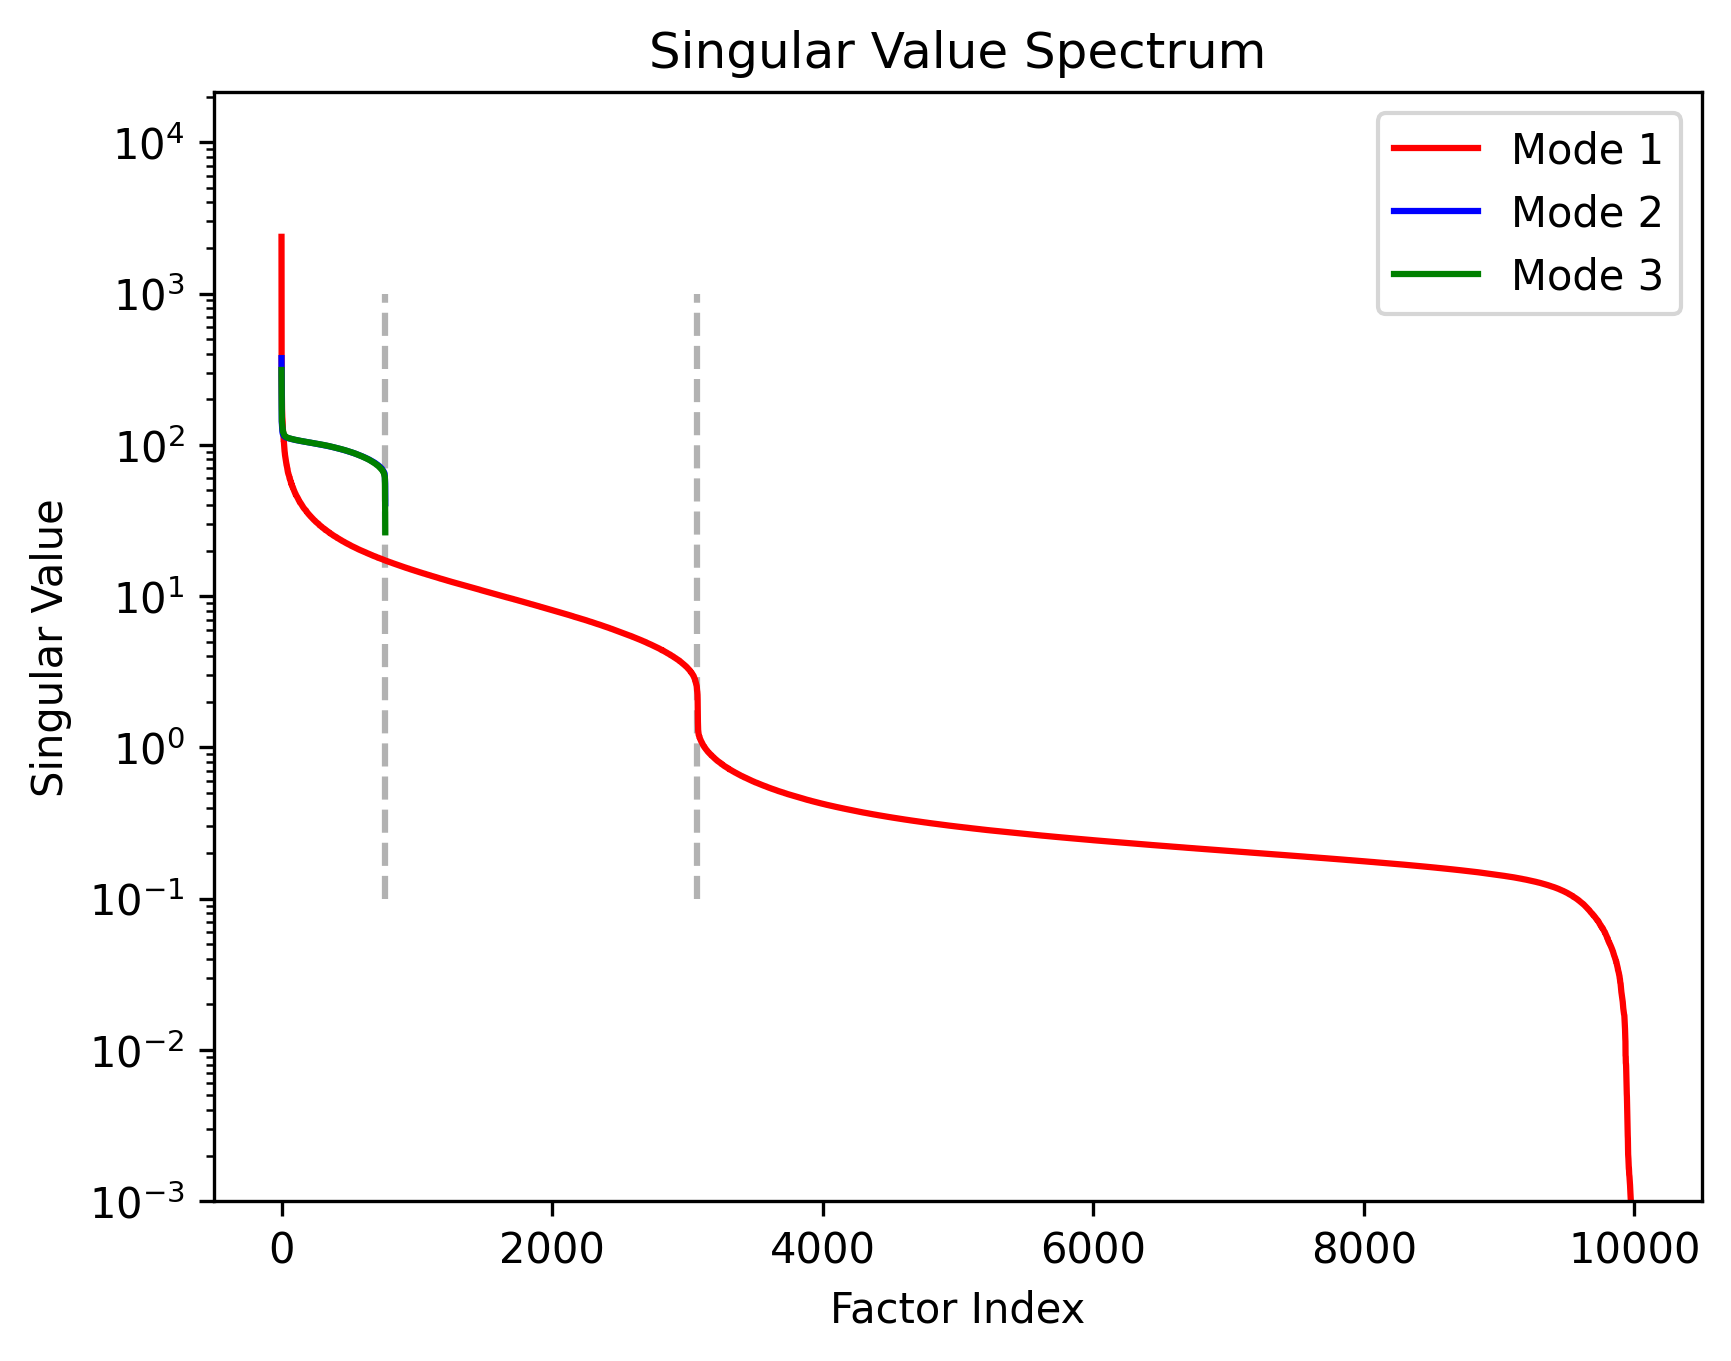

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the singular values S1, S2, S3 from HOSVD
[S1, S2, S3] = decomp[2]
S1 = S1 #.detach().cpu()
S2 = S2 #.detach().cpu()
S3 = S3 #.detach().cpu()

# Singular Value Spectrum
plt.figure()
plt.plot([768, 768], [1e-1, 1e3], 'k--', alpha=0.3)
plt.plot([768*4, 768*4], [1e-1, 1e3], 'k--', alpha=0.3)
plt.semilogy(S1, 'r-', label='Mode 1')
plt.semilogy(S2, 'b-', label='Mode 2')
plt.semilogy(S3, 'g-', label='Mode 3')
plt.xlabel('Factor Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum')
plt.legend()
plt.ylim(1e-3, None)
# plt.xlim(None, 4000)
plt.show()

# Cumulative Singular Value Sum
# cumsum_S1 = torch.cumsum(S1**2, dim=0) / torch.sum(S1**2)
# cumsum_S2 = torch.cumsum(S2**2, dim=0) / torch.sum(S2**2)
# cumsum_S3 = torch.cumsum(S3**2, dim=0) / torch.sum(S3**2)


# plt.figure()
# plt.plot(cumsum_S1, 'r-', label='Mode 1')
# plt.plot(cumsum_S2, 'b-', label='Mode 2')
# plt.plot(cumsum_S3, 'g-', label='Mode 3')
# plt.xlabel('Number of Factors')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Singular Value Sum')
# plt.legend()
# plt.show()


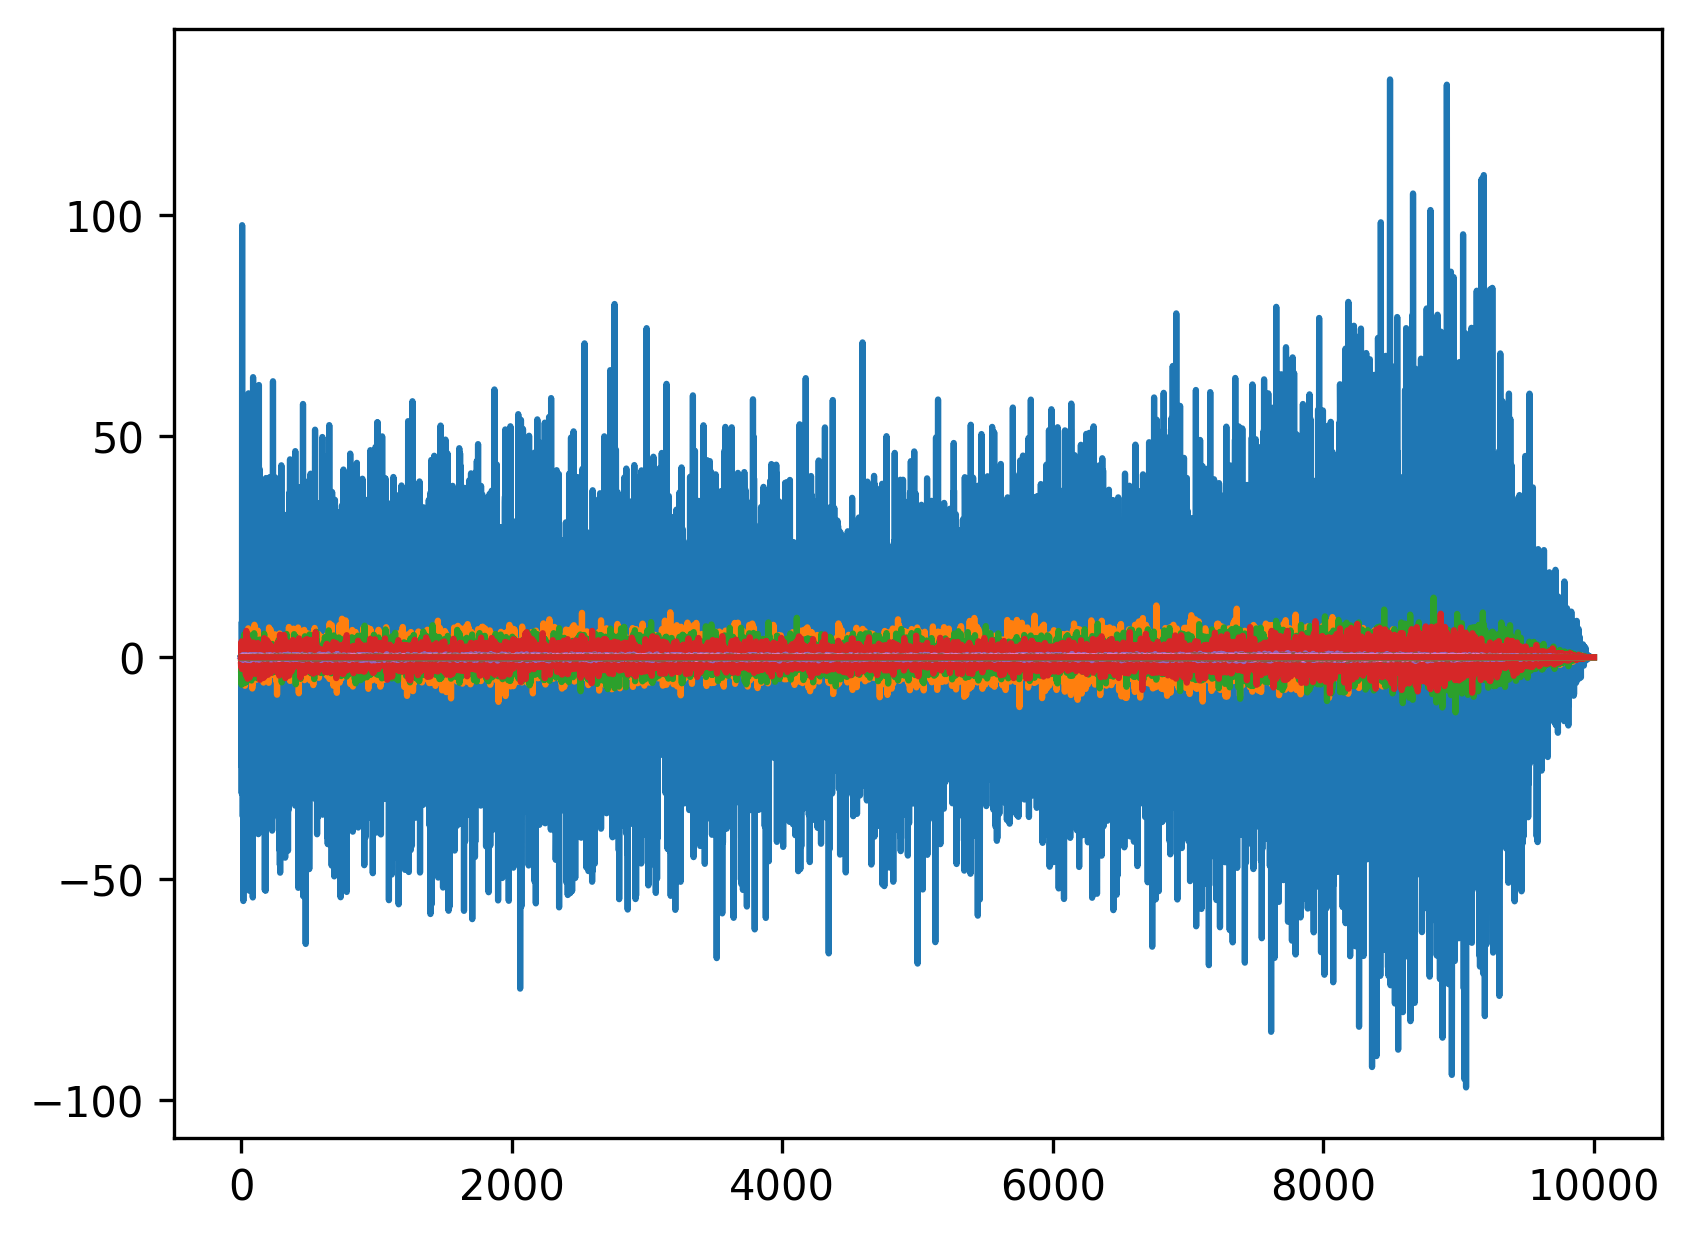

In [ ]:
U1s = decomp[1][0]
S1s = decomp[2][0]
indices = [0, 1, 2, 3, 500, 1000, 2000, 3000, 3071, 3072, 3073, 5000, 9000, -1]

for U1, S1 in zip(U1s[indices], S1s[indices]):
    plt.plot(U1 * S1)
plt.show()

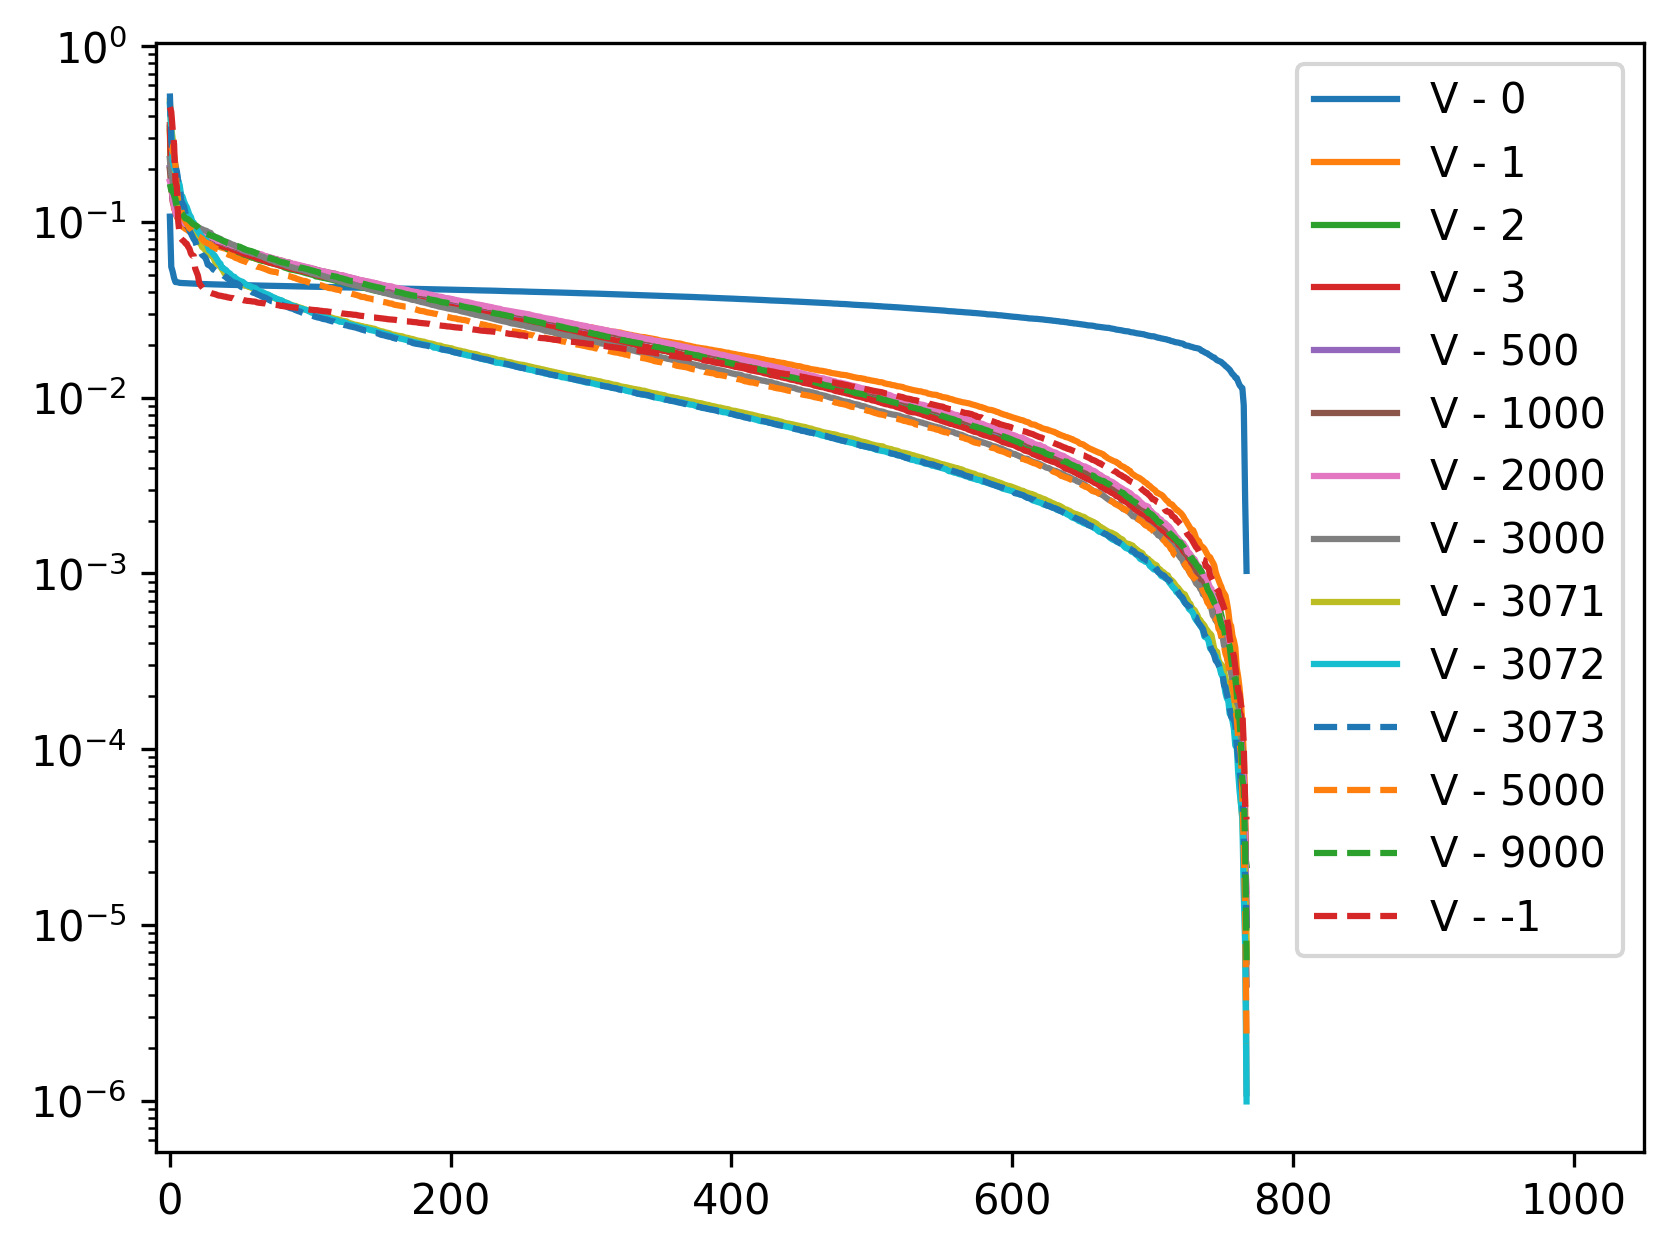

In [ ]:
for idx, v in enumerate(decomp[3][0][indices]):
    v = v.reshape(768, 768)
    ui, si, vi = np.linalg.svd(v, full_matrices=False)
    fmt = "-"
    if idx > 9:
        fmt = "--"
    plt.semilogy(si, fmt, label=f"V - {indices[idx]}")
plt.title
plt.legend()
plt.xlim(-10, 1050)
plt.show()

In [ ]:
from tensorly.decomposition import parafac
factors = parafac(Js.numpy(), rank=10)

tensor([[[ 7.8431e-01,  2.1982e-02,  2.7709e-03,  ...,  3.6592e-04,
          -3.8842e-02, -1.0308e-02],
         [ 1.7792e-02,  7.6502e-01,  3.1669e-02,  ..., -8.4247e-03,
           2.8113e-03, -9.2181e-05],
         [-1.4302e-03,  8.1672e-03,  7.8085e-01,  ..., -5.9051e-05,
           4.8666e-02, -2.0408e-02],
         ...,
         [-2.0907e-02,  5.1730e-03,  1.2213e-02,  ...,  6.7433e-01,
           1.6020e-02, -1.9905e-03],
         [-3.1440e-02, -2.6711e-02,  1.5062e-03,  ..., -3.1803e-02,
           7.2179e-01, -3.6097e-03],
         [ 4.7631e-03,  5.4799e-03,  2.5858e-02,  ...,  1.3344e-02,
          -8.1334e-03,  7.7753e-01]],

        [[ 8.0705e-01, -8.7300e-04,  1.6105e-02,  ...,  1.2332e-02,
          -4.4640e-02, -7.3714e-03],
         [ 2.6024e-03,  8.1658e-01, -9.2355e-03,  ..., -1.5945e-02,
          -1.2634e-02, -3.4954e-02],
         [ 4.9742e-03,  7.0870e-03,  8.0471e-01,  ..., -2.0331e-02,
           1.2792e-02,  8.4004e-03],
         ...,
         [ 1.7325e-02,  1